matplotlib 3.10.6 downgraded to 3.7.5 to work with pycomplexheatmap

## 1.Load Data

Load the data into your chosen programming language (R or python recommended). What size is your expression matrix? How many genes does it include? How much variation do you see in the data? To answer these questions, log-scale the data, calculate per-gene median expression ranges, then make a density plot showing those results. Summarize your findings.


Expr.shape: (43363, 117) 

Gene ranges:
 Gene
ENSG00000000003    0.914760
ENSG00000000005    1.207773
ENSG00000000419    0.500279
ENSG00000000457    0.400948
ENSG00000000460    0.484382
dtype: float64 



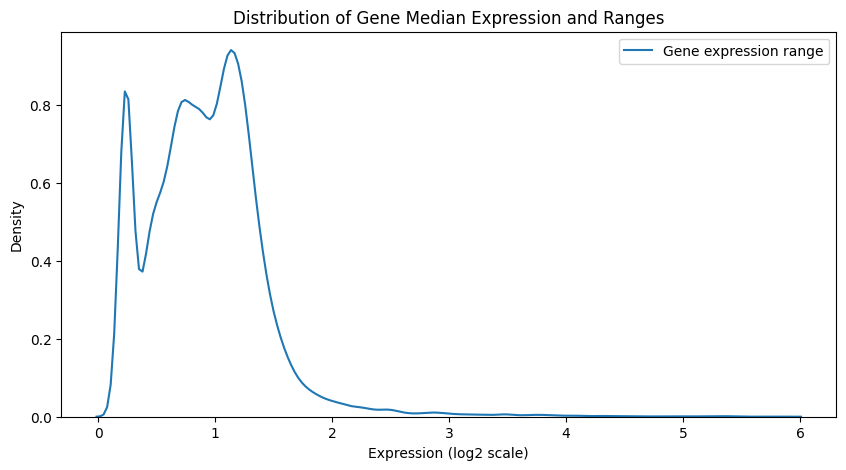

'Summary of findings\nThe distribution of gene median expressions is centered at zero and is skewed to the right. \nThis means that a majority of genes with a median near zero are either lowly expressed or off.\nThe genes in the right tail are expressed at moderate to high rates across samples. \n\nThe distribution of gene expression ranges is bimodal. Still, most of the ranges fall between zero to two,\nmeaning that most of the genes are fairly stable across samples and likely have a housekeeping-like role.\n'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load gene expression and metadata into pandas dataframes
expr = pd.read_csv("data/SRP075806/SRP075806.tsv", sep='\t')
meta = pd.read_csv("data/SRP075806/metadata_SRP075806.tsv", sep='\t')

# What size is the expression matrix?
# 43363 genes and 117 samples
print("Expr.shape:", expr.shape, '\n')

# Log-transform gene data
expr = expr.set_index("Gene")
expr_log = np.log2(expr+1)

'''# Find out if we need to split up # Per-gene median
gene_medians = expr_log.median(axis=1)
print("Gene medians:\n", gene_medians.head(), '\n')
'''

# Expression ranges
gene_ranges = expr_log.max(axis=1) - expr_log.min(axis=1)
print("Gene ranges:\n", gene_ranges.head(), '\n')

# Density plot
plt.figure(figsize=(10,5))
#sns.kdeplot(gene_medians, label="Gene median expression")
sns.kdeplot(gene_ranges, label="Gene expression range")
plt.xlabel("Expression (log2 scale)")
plt.ylabel("Density")
plt.title("Distribution of Gene Median Expression and Ranges")
plt.legend()
plt.show()

"""Summary of findings
The distribution of gene median expressions is centered at zero and is skewed to the right. 
This means that a majority of genes with a median near zero are either lowly expressed or off.
The genes in the right tail are expressed at moderate to high rates across samples. 

The distribution of gene expression ranges is bimodal. Still, most of the ranges fall between zero to two,
meaning that most of the genes are fairly stable across samples and likely have a housekeeping-like role.
"""

## 2. Generate a PCA plot

d:\projects\cgs4144_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\projects\cgs4144_project\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


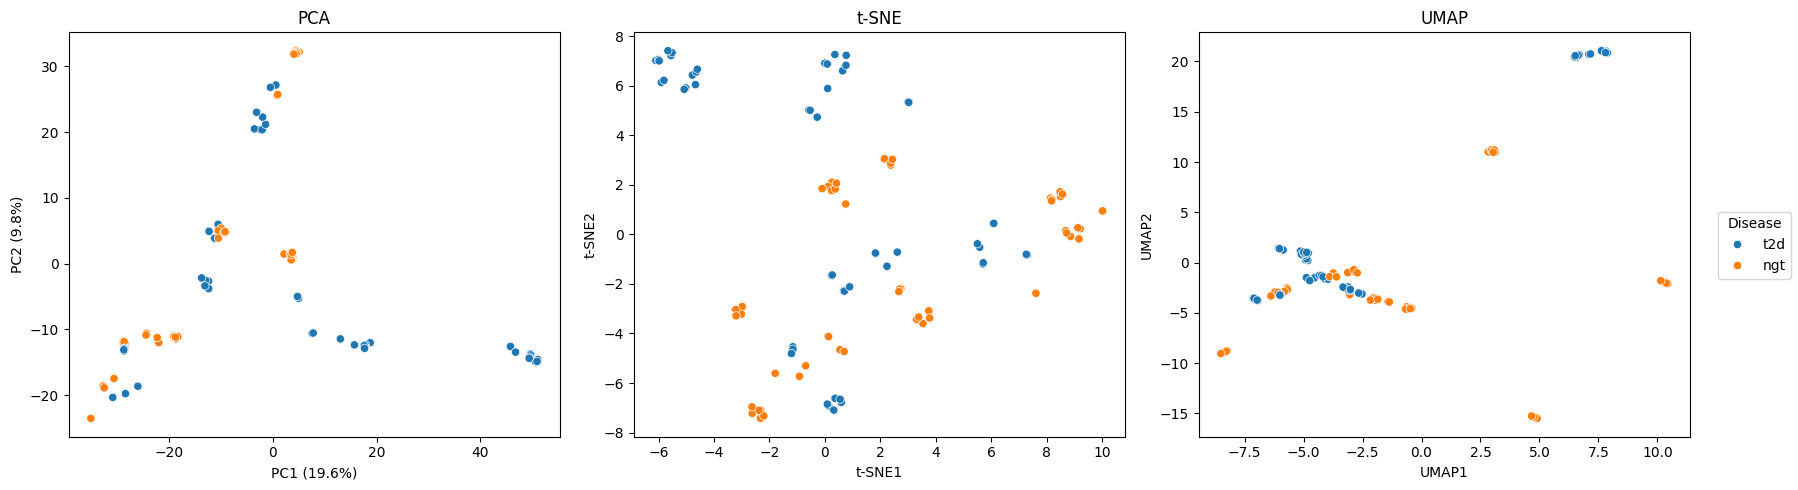

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

meta = meta.set_index('refinebio_accession_code')
meta = meta.loc[expr_log.columns]

labels = meta['refinebio_disease']
labels

pca = PCA(n_components=2, random_state=13)
pca_coords = pca.fit_transform(expr_log.T)

tsne = TSNE(n_components=2, perplexity=30, random_state=13)
tsne_coords = tsne.fit_transform(expr_log.T)

um = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=13)
umap_coords = um.fit_transform(expr_log.T)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=pca_coords[:,0], y=pca_coords[:,1], hue=labels, ax=axes[0])
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axes[0].set_title("PCA")
axes[0].legend_.remove()

sns.scatterplot(x=tsne_coords[:,0], y=tsne_coords[:,1], hue=labels, ax=axes[1])
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")
axes[1].set_title("t-SNE")
axes[1].legend_.remove()

sns.scatterplot(x=umap_coords[:,0], y=umap_coords[:,1], hue=labels, ax=axes[2])
axes[2].set_xlabel("UMAP1")
axes[2].set_ylabel("UMAP2")
axes[2].set_title("UMAP")
axes[2].legend_.remove()

handles, labels_text = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_text, title="Disease", loc="center right")

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

## 3. Differential Analysis

In [3]:
print(expr_log.head().to_string())

                 SRR3593218  SRR3593219  SRR3593220  SRR3593221  SRR3593222  SRR3593223  SRR3593224  SRR3593225  SRR3593226  SRR3593227  SRR3593228  SRR3593229  SRR3593230  SRR3593231  SRR3593232  SRR3593233  SRR3593234  SRR3593236  SRR3593237  SRR3593238  SRR3593239  SRR3593240  SRR3593241  SRR3593242  SRR3593243  SRR3593244  SRR3593245  SRR3593246  SRR3593247  SRR3593248  SRR3593249  SRR3593250  SRR3593251  SRR3593252  SRR3593253  SRR3593254  SRR3593256  SRR3593257  SRR3593258  SRR3593260  SRR3593261  SRR3593262  SRR3593263  SRR3593264  SRR3593265  SRR3593266  SRR3593267  SRR3593268  SRR3593269  SRR3593270  SRR3593271  SRR3593272  SRR3593273  SRR3593274  SRR3593275  SRR3593276  SRR3593277  SRR3593278  SRR3593279  SRR3593280  SRR3593281  SRR3593282  SRR3593283  SRR3593284  SRR3593285  SRR3593286  SRR3593287  SRR3593288  SRR3593289  SRR3593290  SRR3593291  SRR3593292  SRR3593293  SRR3593294  SRR3593295  SRR3593296  SRR3593297  SRR3593298  SRR3593299  SRR3593300  SRR3593301  SRR3593306 

In [4]:
print(meta.head().to_string())

           experiment_accession  refinebio_age  refinebio_cell_line  refinebio_compound  refinebio_developmental_stage refinebio_disease  refinebio_disease_stage  refinebio_genetic_information refinebio_organism                       refinebio_platform  refinebio_processed  refinebio_processor_id refinebio_processor_name refinebio_processor_version  refinebio_race refinebio_sex  refinebio_source_archive_url refinebio_source_database  refinebio_specimen_part        refinebio_subject  refinebio_time          refinebio_title  refinebio_treatment  MetaSRA_age
SRR3593218            SRP075806           60.0                  NaN                 NaN                            NaN               t2d                      NaN                            NaN       HOMO_SAPIENS  Illumina HiSeq 2000 (IlluminaHiSeq2000)                 True                     596                 Tximport                    v1.37.20             NaN          male                           NaN                       SRA  

d:\projects\cgs4144_project\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


10000
20000
30000
40000


d:\projects\cgs4144_project\.venv\lib\site-packages\bioinfokit\visuz.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate


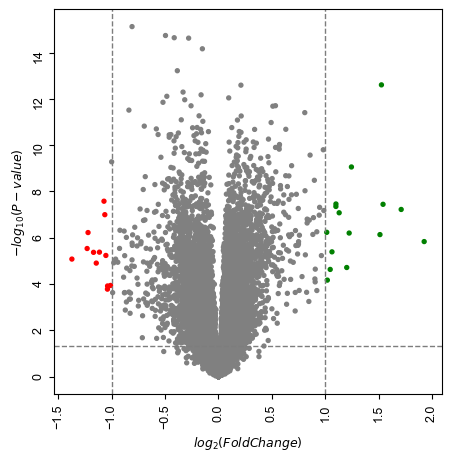

In [5]:
from scipy import stats
from bioinfokit import visuz

# Calculate log2 fold change
case   = meta.index[meta['refinebio_disease'] == 't2d'] # type 2 diabetes
expr_case = expr_log[case]

control = meta.index[meta['refinebio_disease'] == 'ngt'] # normal glucose tolerance
expr_control = expr_log[control]

expr_log['log2FC'] = expr_case.mean(axis=1) - expr_control.mean(axis=1) # log 2 fold change

# Calculate p-value using 2-sided t-test
pvals = []
c = 0 # counter
for gene in expr_log.index:
    t, p = stats.ttest_ind(expr_case.loc[gene], expr_control.loc[gene], equal_var=False)
    pvals.append(p)
    
    # increment and output counter
    c+=1
    if c % 10000 == 0:
        print(c)

expr_log['p-value'] = pvals # save to existing df

# Create volcano plot
visuz.GeneExpression.volcano(
    df=expr_log,
    lfc='log2FC',          # column with log2 fold-change
    pv='p-value',          # column with p-values
    lfc_thr=(1.0, 1.0),    # |log2FC| >= 1 considered significant
    pv_thr=(0.05, 0.05),   # p-value cutoff
    sign_line=True,        # draw threshold lines
    show=True              # display instead of saving to file
)

## 4. Significantly differentially expressed genes

In [6]:
print(expr_log.head().to_string())
print(meta.head().to_string())

                 SRR3593218  SRR3593219  SRR3593220  SRR3593221  SRR3593222  SRR3593223  SRR3593224  SRR3593225  SRR3593226  SRR3593227  SRR3593228  SRR3593229  SRR3593230  SRR3593231  SRR3593232  SRR3593233  SRR3593234  SRR3593236  SRR3593237  SRR3593238  SRR3593239  SRR3593240  SRR3593241  SRR3593242  SRR3593243  SRR3593244  SRR3593245  SRR3593246  SRR3593247  SRR3593248  SRR3593249  SRR3593250  SRR3593251  SRR3593252  SRR3593253  SRR3593254  SRR3593256  SRR3593257  SRR3593258  SRR3593260  SRR3593261  SRR3593262  SRR3593263  SRR3593264  SRR3593265  SRR3593266  SRR3593267  SRR3593268  SRR3593269  SRR3593270  SRR3593271  SRR3593272  SRR3593273  SRR3593274  SRR3593275  SRR3593276  SRR3593277  SRR3593278  SRR3593279  SRR3593280  SRR3593281  SRR3593282  SRR3593283  SRR3593284  SRR3593285  SRR3593286  SRR3593287  SRR3593288  SRR3593289  SRR3593290  SRR3593291  SRR3593292  SRR3593293  SRR3593294  SRR3593295  SRR3593296  SRR3593297  SRR3593298  SRR3593299  SRR3593300  SRR3593301  SRR3593306 

Significant genes: 27 

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


d:\projects\cgs4144_project\.venv\lib\site-packages\PyComplexHeatmap\clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
d:\projects\cgs4144_project\.venv\lib\site-packages\PyComplexHeatmap\clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 19.051388888888887 mm


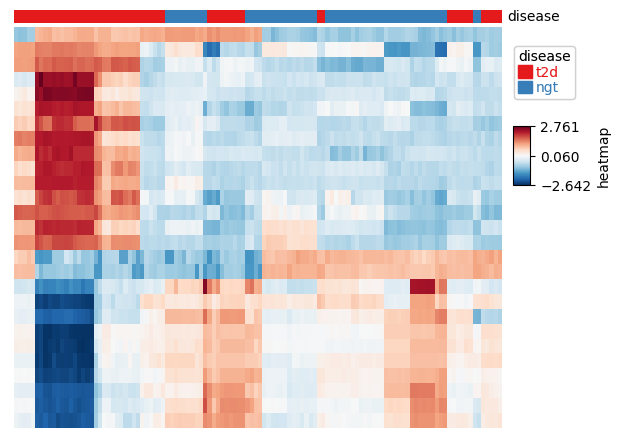

In [7]:
from PyComplexHeatmap import ClusterMapPlotter, HeatmapAnnotation

# Keep only significant genes
sig = expr_log[(expr_log["p-value"] < 0.05) & (expr_log["log2FC"].abs() >= 1)]
print("Significant genes:", sig.shape[0], '\n')
sample_cols = expr_log.columns.difference(["log2FC", "p-value"])
sig_expr = sig[sample_cols]

# z-score by gene
z_scores = (sig_expr - sig_expr.mean(axis=1).values[:, None]) / sig_expr.std(axis=1).values[:, None]

group_colors = {'t2d': '#E41A1C', 'ngt': '#377EB8'}

ha_col = HeatmapAnnotation(
    disease=meta.loc[z_scores.columns, 'refinebio_disease'],
    cmap=group_colors,
    legend=True,
    legend_kws={'title': 'Group'}
)

ClusterMapPlotter(
    data=z_scores,
    top_annotation=ha_col,
    row_cluster=True,
    col_cluster=True,
    cmap="RdBu_r",
    show_rownames=False
)
plt.show()

## 5. Gene enrichment analysis

i.	topGO

ii.	clustProfiler

iii.	gProfiler2

iv.	GenomicSuperSignature

v.	PyDESeq2 (BioStars example here)

vi.	Wilcoxon rank-sum test


### Sean - gProfiler2

Number of significant genes to test: 27
  source      native                              name       p_value  \
0  GO:BP  GO:0003012             muscle system process  6.880690e-11   
1  GO:BP  GO:0006936                muscle contraction  2.247026e-10   
2  GO:BP  GO:0055002  striated muscle cell development  5.635414e-10   
3  GO:BP  GO:0055001           muscle cell development  2.129222e-09   
4  GO:BP  GO:0030239                myofibril assembly  6.098492e-09   

   significant                                        description  term_size  \
0         True  "An organ system process carried out at the le...        438   
1         True  "A process in which force is generated within ...        349   
2         True  "The process whose specific outcome is the pro...        171   
3         True  "The process whose specific outcome is the pro...        198   
4         True  "Formation of myofibrils, the repeating units ...         76   

   query_size  intersection_size  effective_do

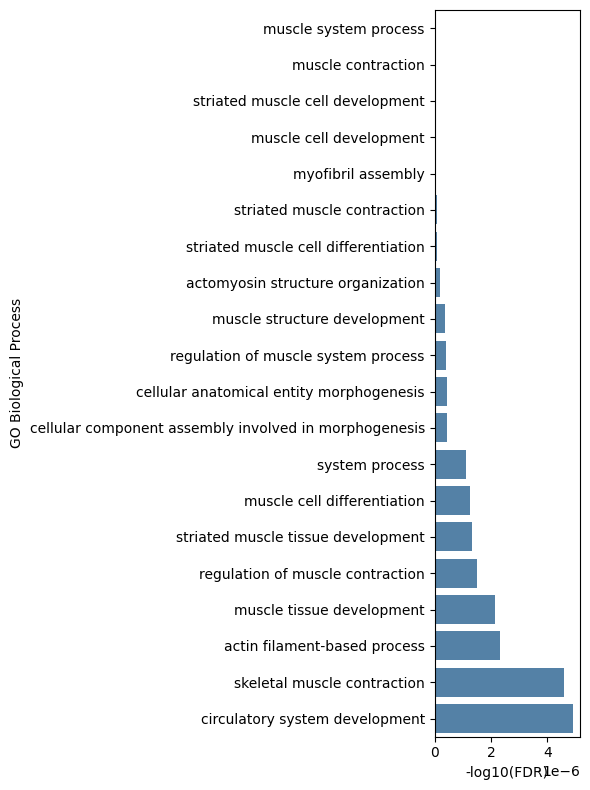

In [ ]:
# gProfiler2
sig_genes = sig.index.tolist()
print("Number of significant genes to test:", len(sig_genes))

from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
gost_results = gp.profile(
    organism='hsapiens',
    query=sig_genes,
    sources=['GO:BP'],
)

# Filter for FDR < 0.05
gost_sig = gost_results[gost_results['p_value'] < 0.05]
print(gost_sig.head())

# Save to your results folder
#gost_sig.to_csv("results/enrichment_GO_BP.csv", index=False)

import seaborn as sns
import matplotlib.pyplot as plt

top_terms = gost_sig.sort_values('p_value').head(20)
plt.figure(figsize=(6,8))
sns.barplot(
    data=top_terms,
    y='name',
    x='p_value',
    color='steelblue'
)
plt.xlabel('-log10(FDR)')
plt.ylabel('GO Biological Process')
plt.tight_layout()
plt.show()


### Daniel

### Tatum

### Amilcar

### Joshua

## 6. Table of statistically significantly enriched terms

## 7. Combined table

## 8. Summary of each table/plot

## 9. Combine all results into a single file